# Introduction 

Body fat percentage is total mass of fat divided by total body mass. It is an important evaluation of a person's health level, too high or too low might cause diseases. There already some body fat calculators online. However, they usually require too many variables while some of them cannot be obtained easily. In this project, we try to construct a simple, accurate and robust model to predict body fat percentage which obeys the 'Rule of Thumb'.

The dataset we use contains 252 male observations and 15 useful variables, including "Bodyfat" as response and some others as predictors.

In [1]:
library(car)
library(leaps)
library(faraway)
library(glmnet)
library(ggplot2)
library(grid)
setwd("C:/Users/Mark Wei/Desktop/628/Project 2")

Loading required package: carData
Registered S3 methods overwritten by 'lme4':
  method                          from
  cooks.distance.influence.merMod car 
  influence.merMod                car 
  dfbeta.influence.merMod         car 
  dfbetas.influence.merMod        car 

Attaching package: 'faraway'

The following objects are masked from 'package:car':

    logit, vif

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-18



# Modeling

## Data cleaning

First, we read the raw data and clean it (detect and delete abnormal observations). There are two criteria to extract abnormal observations: First is to delete those with abnormal feature values, such as a very short observation; Second is to delete those with wrong relationship among some related values. For second criteria there are two formulas, we have to check whether the points obey both of them: 
$$ BODYFAT \propto \frac{1}{DENSITY} \quad ; \quad ADIPOSITY \propto \frac{WEIGHT}{{HEIGHT}^2}$$

In [2]:
DATA = read.csv("BodyFat.csv", row.names = 1)
data = DATA
data$IDNO = 1:length(data$BODYFAT)
# boxplot(data,main="boxplot of rawdata",cex.axis=0.4)      

# data cleaning 
# detect points which bodyfat does not have a linear relationship of 1 / density
#########?????????????????????????????????#########
# plot(data$BODYFAT,data$DENSITY,xlab="bodyfat",ylab="density")
# text(1:length(data[,1]), data$BODYFAT, 1:length(data[,1]),cex=0.5)

##########siri##########
####182,48,76,96#######
data$Bodyfat = 495*(1/data$DENSITY)-450
data$sirilabel = ifelse(abs(data$Bodyfat-data$BODYFAT)>sort(abs(data$Bodyfat-data$BODYFAT),decreasing = T)[5],data$IDNO,"")
plot.siri = ggplot(data = data, aes(x =IDNO,y = Bodyfat-BODYFAT, colour = factor(sirilabel)))+ geom_point()+geom_text(data = data,aes(x = IDNO,y = Bodyfat-BODYFAT,label = sirilabel))

##########BMI##########
####163???221???42#####
data$BMI=703*(data$WEIGHT/(data$HEIGHT)^2)
data$bmilabel = ifelse(abs(data$BMI-data$ADIPOSITY)>sort(abs(data$BMI-data$ADIPOSITY),decreasing = T)[4],data$IDNO,"")
plot.bmi = ggplot(data = data, aes(x =IDNO,y = BMI-ADIPOSITY, colour = factor(bmilabel)))+ geom_point()+geom_text(data = data,aes(x = IDNO,y = BMI-ADIPOSITY,label = bmilabel))

#we should get rid of the density 
DATA_new = DATA[, -2]
DATA_new = DATA_new[-c(42, 48, 76, 96, 163, 182, 221),]

########## Before removing the data points with large cook's distance##########
model0 = lm(BODYFAT ~ .,data = DATA[,-2])
data$cook = cooks.distance(model0)
data$cooklabel = ifelse(data$cook>0.02,data$IDNO,"")
plot.cook = ggplot(data = data, aes(x = IDNO, y = cook, colour = factor(cooklabel)))+ geom_point()+geom_text(data = data,aes(x = IDNO,y = cook,label = cooklabel))

In [3]:
# Check the cook's distance one by one
#########cook###################     
k = 14 ###### number of variables
n = length(DATA$BODYFAT)
index = 1:n
index = index[-c(39,182,48,76,96,163,221,42)]
while(TRUE){
  a = qf(0.5,k,n-k)
  model1<- lm(BODYFAT ~ ., data = DATA_new)
  cook = cooks.distance(model1)
  if(sum(cook>0.5)>0){
    DATA_new = DATA_new[-which.max(cook),]
    index = index[-which.max(cook)]
    n = n-1
  }else{break}
}
out = setdiff(1:length(data$BODYFAT),index)
######cook.distance > F_0.5(k,n-k)####### 

# plot(model1, which = 4)
# deleted the possible outliers 39
data[out,]

,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,...,BICEPS,FOREARM,WRIST,IDNO,Bodyfat,sirilabel,BMI,bmilabel,cook,cooklabel
39,33.8,1.0202,46,363.15,72.25,48.9,51.2,136.2,148.1,147.7,...,45.0,29.0,21.4,39,35.1989806,,48.90640,,0.4063449838,39
42,31.7,1.0250,44,205.00,29.50,29.9,36.6,106.0,104.3,115.5,...,33.6,28.7,17.4,42,32.9268293,,165.60184,42,1.9101411352,42
48,6.4,1.0665,39,148.50,71.25,20.6,34.6,89.8,79.5,92.7,...,28.8,26.8,17.9,48,14.1350211,48,20.56421,,0.0016106446,
76,18.3,1.0666,61,148.25,67.50,22.9,36.0,91.6,81.8,94.8,...,29.3,27.0,18.3,76,14.0915057,76,22.87402,,0.0054526107,
96,17.3,1.0991,53,224.50,77.75,26.1,41.1,113.2,99.2,107.5,...,32.9,30.8,20.4,96,0.3684833,96,26.10784,,0.0005903079,
163,13.3,1.0690,33,184.25,68.75,24.4,40.7,98.9,92.1,103.5,...,33.5,30.6,19.7,163,13.0495790,,27.40422,163,0.0025811189,
182,0.0,1.1089,40,118.50,68.00,18.1,33.8,79.3,69.4,85.0,...,27.7,24.6,16.5,182,-3.6116873,182,18.01590,,0.0077665106,
221,12.7,1.0706,54,153.25,70.50,24.5,38.5,99.0,91.8,96.2,...,31.4,29.9,18.9,221,12.3575565,,21.67592,221,0.0225311932,221


No.39 has too large weight (it is also a possible outlier); No.42 is way too short; No.48, 76, 96, 182 does not match the relationship between bodyfat and density; No.182 also has bodyfat 0, it is a mistake. No.42, 163, 221 don't obey the BMI equation.
We remove them and scale the data to get a new dataset. Then check the Cook's distance again.

In [4]:
data_clean = DATA_new[-39, ]#remove some potential outliers
data_clean = data.frame(scale(data_clean))#scale the data
write.csv(data_clean,"bodyfat_clean.csv",row.names = F)
#check the cook's distance again
model = lm(BODYFAT ~ ., data = data_clean)
#plot(model, which = 4)

#outlier test
outlierTest(model)

No Studentized residuals with Bonferroni p < 0.05
Largest |rstudent|:
     rstudent unadjusted p-value Bonferroni p
224 -2.555635            0.01125           NA

In [5]:
ndata = data[-c(out),]
model10 = lm(BODYFAT ~ .,data = DATA[-c(out),-2])
ndata$cook = cooks.distance(model10)
ndata$cooklabel = ifelse(ndata$cook>0.02,data$IDNO,"")
plot.cook.new = ggplot(data = ndata, aes(x = IDNO, y = cook, colour = factor(cooklabel)))+ geom_point()+geom_text(data = ndata,aes(x = IDNO,y = cook,label = cooklabel))

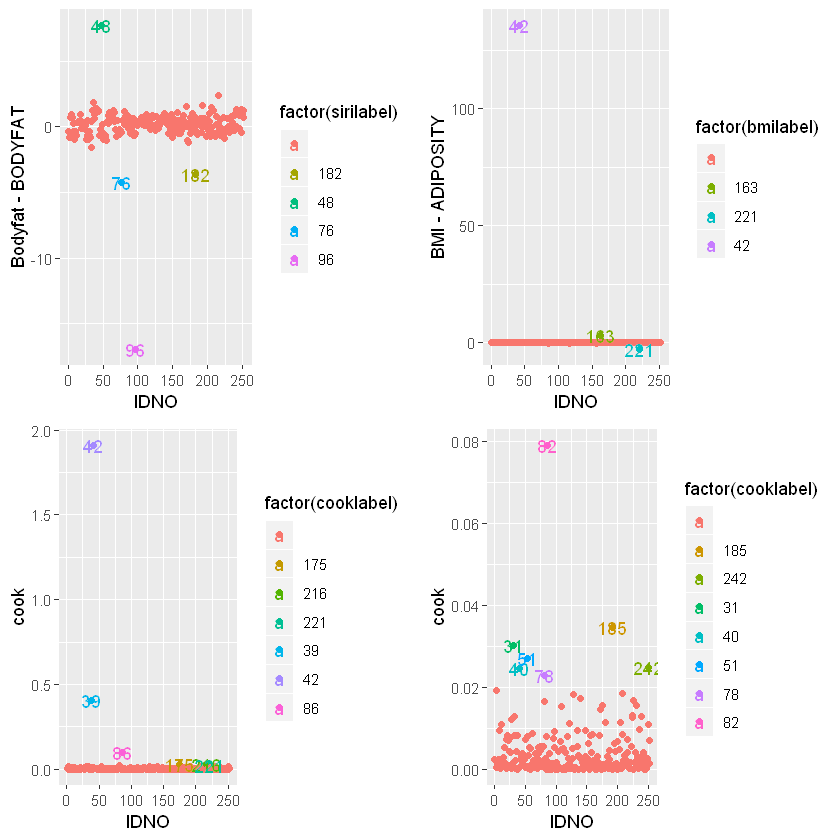

In [6]:
grid.newpage()
pushViewport(viewport(layout = grid.layout(2,2)))

print(plot.siri, vp = viewport(layout.pos.row = 1, layout.pos.col = 1))
print(plot.bmi,  vp = viewport(layout.pos.row = 1, layout.pos.col = 2))
print(plot.cook, vp = viewport(layout.pos.row = 2, layout.pos.col = 1))
print(plot.cook.new, vp = viewport(layout.pos.row = 2, layout.pos.col = 2))

## Model Selection

In [7]:
full = lm(BODYFAT ~ ., data = data_clean)
base = lm(BODYFAT ~ 1, data = data_clean)

### Comparison of different models

# AIC 
# backward
model_AIC_b = step(full, direction = "backward", trace = 0)
print(model_AIC_b)
summary(model_AIC_b)

# forward
model_AIC_f = step(base, direction = "forward", trace = 0,scope = list(lower = base, upper = full))
print(model_AIC_f)
# both sides
model_AIC_t = step(base, direction = "both", trace = 0, scope = list(lower = base, upper = full))
print(model_AIC_t)

# BIC
# backward
n = dim(data)[1]
model_BIC_b = step(full, direction = "backward", trace = 0, k = log(n))
print(model_BIC_b)
summary(model_BIC_b)
# forward
model_BIC_f = step(base, direction = "forward", trace = 0, scope = list(lower = base, upper = full), k = log(n))
print(model_BIC_f )

# both sides
model_BIC_t = step(full, direction = "both", trace = 0, k = log(n))
print(model_BIC_t)
summary(model_BIC_t)


# mallow's cp
X = data_clean[, -1]
Y = data_clean$BODYFAT
g = leaps(X, Y, nbest = 1)
Cpplot(g)
print(colnames(data_clean)[c(1, 3, 6, 7, 12, 14) + 1])
cp_model = BODYFAT ~ AGE + HEIGHT + CHEST + ABDOMEN +  BICEPS + WRIST
cp_lm = lm(cp_model, data=data_clean)
summary(cp_lm)

# adjusted R square
g_ad = leaps(X, Y, nbest = 1,method="adjr2")
plot(g_ad$adjr2)
(g_ad$which)[which(g_ad$adjr2==max(g_ad$adjr2)),]
Ad_r=BODYFAT~AGE+ADIPOSITY+NECK+CHEST+ABDOMEN+HIP+BICEPS+FOREARM+WRIST
adr_model<-lm(Ad_r,data=data_clean)
summary(adr_model)

# lasso
model_l <- glmnet(as.matrix(data_clean[,2:15]), data_clean$BODYFAT, family = "gaussian", nlambda = 50, alpha = 1,standardize = T)
print(model_l)
plot(model_l, xvar = "lambda", label = T)
cvfit <- cv.glmnet(as.matrix(data_clean[,2:15]), data_clean$BODYFAT, family = "gaussian", type.measure = "mse", nfolds = 10,alpha = 1)
plot(cvfit)
print(coef(cvfit, s = "lambda.1se" ))
model_lasso<- BODYFAT ~ AGE + HEIGHT  + ABDOMEN +  WRIST
model_l<-lm(BODYFAT ~ AGE + HEIGHT  + ABDOMEN +  WRIST,data=data_clean)


### Additional analysis

According to the result of these models, we find that "ABDOMEN" is the most important predictor, followed by "WRIST" and "WEIGHT". Because of our "Rule of thumb" criteria, we decide to choose one of "WRIST" and "WEIGHT", then take it along with "ABDOMEN" as our two predictors. Suppose we set "Model 1" using ABDOMEN and WEIGHT to predict BODYFAT, and "Model 2" using ABDOMEN and WRIST to predict BODYFAT.

First we check multicolinearity by correlation and VIF test

#check the possible multicolinearity betweeen abdomen and wrist,weight
cor(data_clean$WRIST,data_clean$ABDOMEN)
cor(data_clean$WEIGHT,data_clean$ABDOMEN)
cor(data_clean$WRIST,data_clean$WEIGHT)
vif(model_BIC_f)
vif(lm(BODYFAT ~ ABDOMEN + WEIGHT, data = data_clean))
vif(lm(BODYFAT ~ ABDOMEN + WRIST, data = data_clean))

By VIF test, we suppose the predictors in "Model 1" are more correlated than "Model 2". Also, we can see the value of R-square are similar between two models. If we only use ABDOMEN to predict, the R-square indicates that's not reliable. So in order to reduce multicolinearity, we choose "Model 2" (ABDOMEN and WRIST) as our final model. 

In [9]:
s1 = summary(lm(BODYFAT ~ ABDOMEN + WRIST, data = data_clean))
s2 = summary(lm(BODYFAT ~ ABDOMEN + WEIGHT, data = data_clean))
s3 = summary(lm(BODYFAT ~ ABDOMEN , data = data_clean))
round(c(s1$r.squared, s2$r.squared,s3$r.squared),3)

[1] 0.715 0.724 0.678

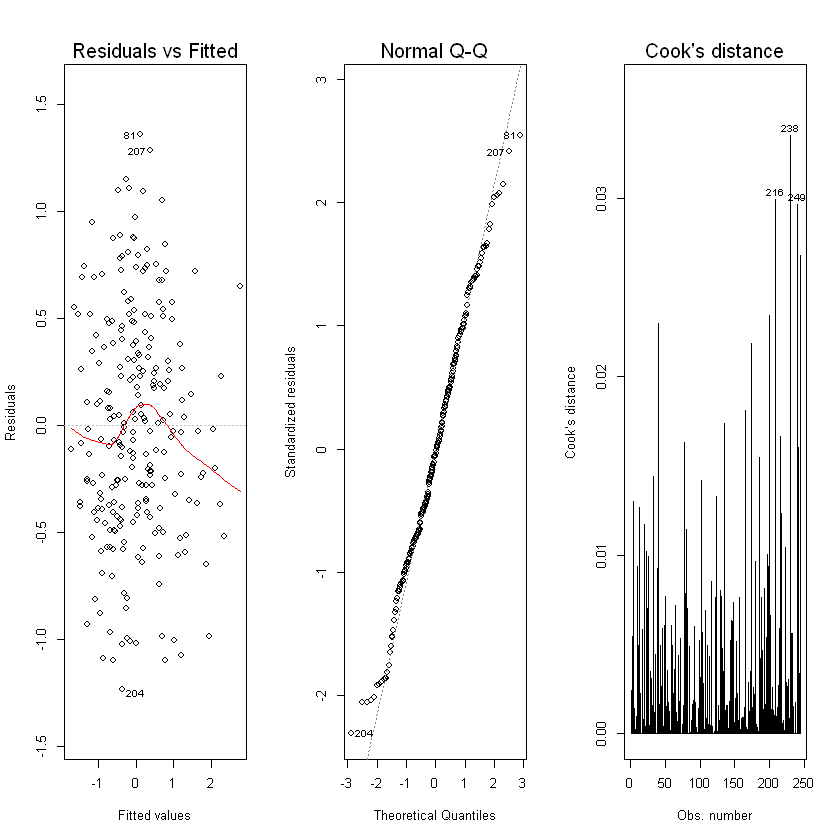

In [10]:
layout(matrix(c(1,2,3), 1, 3, byrow = TRUE))
#plot(data_clean$ABDOMEN,data_clean$BODYFAT,xlab="Abdomen",ylab="Bodyfat",main="final model")
#abline(-38,0.617,col="red")
#plot(data_clean$BODYFAT-(0.62*data_clean$ABDOMEN-38))
final_model<-lm(BODYFAT ~ ABDOMEN + WRIST, data = data_clean)
plot(final_model,which=1)
plot(final_model,which=2)
plot(final_model,which=4)

# Model interpretation and diagnostics 

## Laymen's interpretation: 

Male Bodyfat percentage can be calculated as 0.73 abdomen(cm) minus 2.03 wrist(cm) and then substract 11.2.  
*Example: A male who has abdomen 80cm and wrist 18cm, his bodyfat percentage is around 10.66%.*

## Diagnostics
checking modeling assumptions with plots

## Strengths and weakness 

Advantages of Our Model  
1. Our final model is simple and straightforward. The variables included for prediction is easy to get.  
2. The model is robust.  
3. The model is accurate as the adjusted R-squared is greater than 0.6.  

Weaknesses:   
1. We only consider two variables and ignored the interaction between these variables.                            
2. Our data sample only contains 252 observations, if the weight is too hig or too low, the prediction may not be so accurate.

# Conclusion

# Contribution: 

GUANQI LU: Data cleaning and model building,jupyter notebook summary.  
QIAOCHU YU: Slides and plots using ggplot,jupyter notebook summary.  
HAOXIANG WEI:  Data analyzing and jupyter notebook summary.  
YI-HSUAN TSAI：Shiny App building and jupyter notebook summary.